# Analyze Human Body Temperature Using EDA: Submitted by Ahrim Han (2019/2/20)

# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [11]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
from scipy import stats
import matplotlib.pyplot as plt
import pylab
import seaborn as sns
sns.set()

In [3]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


### 1. Is the distribution of body temperatures normal?
We first draw the histogram.

Text(0.5, 1.0, 'Histogram: Body Temperature')

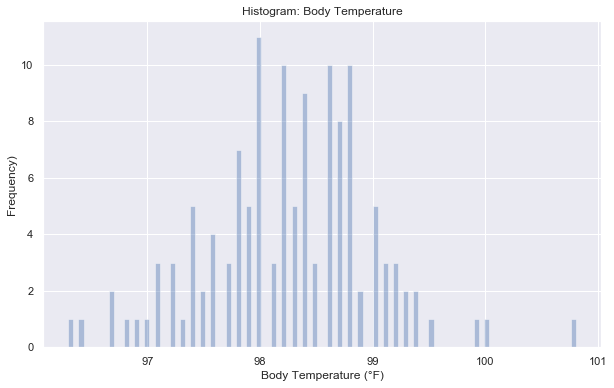

In [5]:
#histogram
#plt.hist(df['temperature'], bins=100, density=True)
plt.figure(figsize=(10,6))
#kernel density estimate (KDE)
sns.distplot(df['temperature'], kde=False, bins = 100)
plt.xlabel('Body Temperature (°F)')
plt.ylabel('Frequency)')
plt.title('Histogram: Body Temperature')

#PDF: Probability Density Function

The sample distribution resembles the normal distribution.

To confirm the normal distribution, we run the normality test to know whether a sample differs from a normal distribution. This function `normaltest` tests the null hypothesis that a sample comes from a normal distribution.

In [50]:
alpha = 0.05
k2, p = stats.normaltest(df['temperature'])
print('p-value = {:.5f}'.format(p))

# null hypothesis: x comes from a normal distribution
if p < alpha:
    print('The null hypothesis can be rejected.')
else:
    print('The null hypothesis cannot be rejected. This ia a normal distribution.')

p-value = 0.25875
The null hypothesis cannot be rejected. This ia a normal distribution.


We defined the `ecdf` (empirical cumulative distribution function). We also simulate a normal distribution of the mean, std, and size of 100 times. At the end, we compared the two plots. The graph shows that the data is a normal distribution.

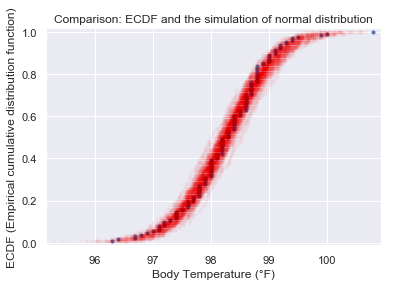

In [20]:
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

#ecdf (empirical cumulative distribution function)
x, y = ecdf(df['temperature'])
_ = plt.plot(x, y, marker='.', linestyle='none')

#Simulate a normal distribution of the mean, std, and size of 100 times
m, s, n = np.mean(df['temperature']), np.std(df['temperature']), len(df['temperature'])
for i in range(100):
    sample = np.random.normal(m, s, n)
    x, y = ecdf(sample)
    _ = plt.plot(x, y, marker = '.', alpha = 0.02, linestyle = 'none', color = 'red')

_ = plt.xlabel('Body Temperature (°F)')
_ = plt.ylabel('ECDF (Empirical cumulative distribution function)')
plt.title('Comparison: ECDF and the simulation of normal distribution')
plt.show()

### 2. Is the sample size large? Are the observations independent?

**Sample size**

In [7]:
print("Sample size:", len(df))

Sample size: 130


The size of the data is greater than 30 and the sample size is large enough.

**Independent observations**

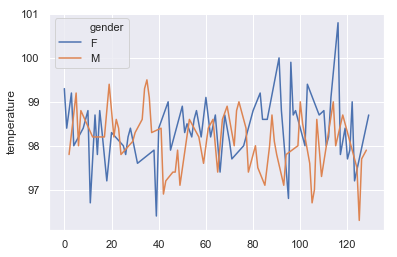

In [8]:
sns.lineplot(x=df.index, y="temperature",
             hue="gender", data=df)

The observations for temperature are independent because one person's temperature does not affect another person's temperature. Furthermore, there is no correlation in the temperatures between males and females.

### 3. Is the true population mean really 98.6 degrees F?

**Bootstrap hypothesis test**

**Step1:** The null and alternative hypothesis are stated:  
- $H_0$: $\mu$ = 98.6  
- $H_a$: $\mu$ $\neq$ 98.6

**Step 2:** We chose the significance level at 5% ($\alpha$ = 0.05).  
**Step 3:** We will use the population mean as our test statistic.  
**Step 4:** The **observed value of the test statistic (e.g., population mean)** is `np.mean(df['temperature'])`. 

In [45]:
np.mean(df['temperature'])

98.24923076923078

We now need the p-value, but to do this we need to know the sampling distribution of our test statistic when the null hypothesis is true.
So our approach is to perform a simulation under conditions in which we know the null hypothesis is true.  


What we will do is use our data to represent population, but first we shift it over so that the mean actually is 98.6.

In [59]:
temp_shifted = df['temperature'] - np.mean(df['temperature']) + 98.6
np.mean(temp_shifted)

98.59999999999992

We now take the bootstrap replicates of the shifted data.
We take out 10,000 observations at random.

In [60]:
def bootstrap_replicate_1d(data, func):
    """Generate a single bootstrap replicate."""
    return func(np.random.choice(data, size=len(data)))

def draw_bs_reps(data, func, size):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

bootstrap_replicates = draw_bs_reps(temp_shifted, np.mean, 10000)

The p-value is the probability of getting something more extreme than what we observed.  
The p-value is computed as the fraction of replicates that are less than the observed temperature.

In [64]:
#98.25 (np.mean(df['temperature'])) is 98.60 - 98.25 = 0.35 (np.mean(shifted) - np.mean(df['temperature'])) units away from the null hypothesis.

p_val = np.sum(bootstrap_replicates <= np.mean(df['temperature'])) / len(bootstrap_replicates)
#print('p-value = %.5f' % (p_val))
print('p-value = {:.5f}'.format(p_val))

p-value = 0.00000


Since p-value is 0, the null hypothesis is rejected. True population mean is unlikely to be 98.6 degrees F.

**Frequentist statistical testing**

### 4. Draw a small sample of size 10 from the data and repeat both frequentist tests.

### 5. At what temperature should we consider someone's temperature to be "abnormal"?

### 6. Is there a significant difference between males and females in normal temperature?